In [142]:
import numpy as np 
import pandas as pd 

In [143]:
import matplotlib.pyplot as plt
import os

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from nltk.corpus import stopwords
from nltk.corpus import wordnet
import string
from string import punctuation

import re

In [144]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sentiments = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [145]:
data = pd.read_csv('https://raw.githubusercontent.com/pycaret/pycaret/master/datasets/amazon.csv')
data.columns

Index(['reviewText', 'Positive'], dtype='object')

In [146]:
data.head()

,reviewText,Positive
0,This is a one of the best apps acording to a b...,1
1,This is a pretty good version of the game for ...,1
2,this is a really cool game. there are a bunch ...,1
3,"This is a silly game and can be frustrating, b...",1
4,This is a terrific game on any pad. Hrs of fun...,1


In [147]:
data.Positive.value_counts()

1    15233
0     4767
Name: Positive, dtype: int64

In [148]:
data1 = data.copy()
data1.columns = ["Comment", "Label"]
data1.head()

,Comment,Label
0,This is a one of the best apps acording to a b...,1
1,This is a pretty good version of the game for ...,1
2,this is a really cool game. there are a bunch ...,1
3,"This is a silly game and can be frustrating, b...",1
4,This is a terrific game on any pad. Hrs of fun...,1


* **Data transformation**

In [149]:
stop_words=set(stopwords.words('english'))
lzr = WordNetLemmatizer()

In [150]:
def text_processing(text):   
    # convert text into lowercase
    text = text.lower()

    # remove new line characters in text
    text = re.sub(r'\n',' ', text)
    
    # remove punctuations from text
    text = re.sub('[%s]' % re.escape(punctuation), "", text)
    
    # remove references and hashtags from text
    text = re.sub("^a-zA-Z0-9$,.", "", text)
    
    # remove multiple spaces from text
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    
    # remove special characters from text
    text = re.sub(r'\W', ' ', text)

    text = ' '.join([word for word in word_tokenize(text) if word not in stop_words])
    
    text=' '.join([lzr.lemmatize(word) for word in word_tokenize(text)])

    return text

In [151]:
nltk.download('omw-1.4')
data_copy = data1.copy()
data_copy.Comment = data_copy.Comment.apply(text_processing)

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [152]:
#difference_counts = (data_copy["Label"] == 1).sum() - (data_copy["Label"] == 0).sum()
data_copy["Label"].value_counts()

1    15233
0     4767
Name: Label, dtype: int64

In [153]:
 from sklearn.utils import resample
    
df_negative = data_copy[(data_copy['Label']==0)]
df_positive = data_copy[(data_copy['Label']==1)]

# upsample minority classes
df_negative_upsampled = resample(df_negative, 
                                 replace=True,    
                                 n_samples=15233, 
                                 random_state=42)  



#  Concatenate the upsampled dataframes
data_copy = pd.concat([df_negative_upsampled,df_positive])

data_copy['Label'].value_counts()

0    15233
1    15233
Name: Label, dtype: int64

In [154]:

sentiments = SentimentIntensityAnalyzer()
data_copy["Positive"] = [sentiments.polarity_scores(i)["pos"] for i in data_copy["Comment"]]
data_copy["Negative"] = [sentiments.polarity_scores(i)["neg"] for i in data_copy["Comment"]]
data_copy["Neutral"] = [sentiments.polarity_scores(i)["neu"] for i in data_copy["Comment"]]
data_copy['Compound'] = [sentiments.polarity_scores(i)["compound"] for i in data_copy["Comment"]]
score = data_copy["Compound"].values
sentiment = []
for i in score:
    if i > 0.0 :
        sentiment.append('Positive')
    else:
        sentiment.append('Negative')
data_copy["Sentiment"] = sentiment

In [155]:
data_copy

,Comment,Label,Positive,Negative,Neutral,Compound,Sentiment
4056,dont buy even free dont download shouldnt rewa...,0,0.111,0.260,0.628,-0.5144,Negative
17480,finally found right calorie counter keep track...,0,0.000,0.000,1.000,0.0000,Negative
14395,playing kindle fire hd great fun crash 4 min g...,0,0.579,0.212,0.208,0.8316,Positive
2483,dont like u go back forth boring go dont think...,0,0.000,0.330,0.670,-0.7105,Negative
18930,app time change view free one soooooooo much b...,0,0.398,0.073,0.528,0.7906,Positive
...,...,...,...,...,...,...,...
19992,love app cant get enough almost like green far...,1,0.368,0.000,0.632,0.7512,Positive
19993,could rate 1000000000000000000000 star honestl...,1,0.549,0.000,0.451,0.9274,Positive
19996,please add need neighbor ginger1016 thanks bun...,1,0.602,0.000,0.398,0.9337,Positive
19997,love game awesome wish free stuff house didnt ...,1,0.556,0.210,0.233,0.8719,Positive


* **Final data**

In [156]:
data2=data_copy.drop(['Positive','Negative','Neutral','Compound'],axis=1)
data2.head()

,Comment,Label,Sentiment
4056,dont buy even free dont download shouldnt rewa...,0,Negative
17480,finally found right calorie counter keep track...,0,Negative
14395,playing kindle fire hd great fun crash 4 min g...,0,Positive
2483,dont like u go back forth boring go dont think...,0,Negative
18930,app time change view free one soooooooo much b...,0,Positive


In [158]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data_copy['VaderSentiment'] = le.fit_transform(data2['Sentiment'])

In [159]:
data_copy['VaderSentiment'].value_counts()

1    21226
0     9240
Name: VaderSentiment, dtype: int64

In [160]:
data_copy.head()

,Comment,Label,Positive,Negative,Neutral,Compound,Sentiment,VaderSentiment
4056,dont buy even free dont download shouldnt rewa...,0,0.111,0.260,0.628,-0.5144,Negative,0
17480,finally found right calorie counter keep track...,0,0.000,0.000,1.000,0.0000,Negative,0
14395,playing kindle fire hd great fun crash 4 min g...,0,0.579,0.212,0.208,0.8316,Positive,1
2483,dont like u go back forth boring go dont think...,0,0.000,0.330,0.670,-0.7105,Negative,0
18930,app time change view free one soooooooo much b...,0,0.398,0.073,0.528,0.7906,Positive,1


In [161]:
processed_data = {
    'Sentence':data_copy.Comment,
    'Label': data_copy.Label,
    'VaderSentiment':data_copy['VaderSentiment']
}

processed_data = pd.DataFrame(processed_data)
processed_data

,Sentence,Label,VaderSentiment
4056,dont buy even free dont download shouldnt rewa...,0,0
17480,finally found right calorie counter keep track...,0,0
14395,playing kindle fire hd great fun crash 4 min g...,0,1
2483,dont like u go back forth boring go dont think...,0,0
18930,app time change view free one soooooooo much b...,0,1
...,...,...,...
19992,love app cant get enough almost like green far...,1,1
19993,could rate 1000000000000000000000 star honestl...,1,1
19996,please add need neighbor ginger1016 thanks bun...,1,1
19997,love game awesome wish free stuff house didnt ...,1,1


In [162]:
processed_data['VaderSentiment'].value_counts()

1    21226
0     9240
Name: VaderSentiment, dtype: int64

In [163]:
final_data = processed_data.copy()

In [164]:
from sklearn.metrics import confusion_matrix
cm1 = confusion_matrix(final_data['Label'], final_data['VaderSentiment'])

In [165]:
cm1

array([[ 7736,  7497],
       [ 1504, 13729]], dtype=int64)

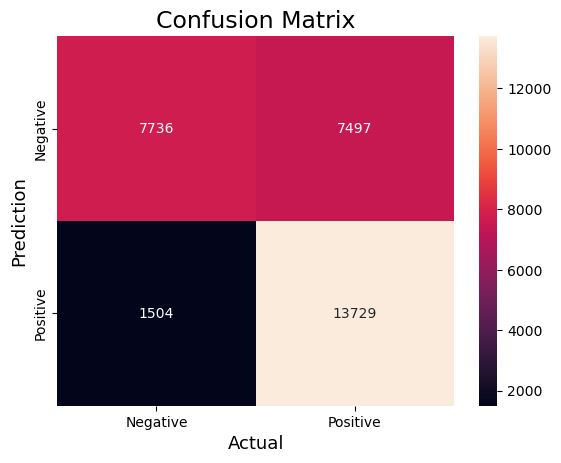

In [166]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm1, 
            annot=True,
            fmt='g', 
            xticklabels=['Negative','Positive'],
            yticklabels=['Negative','Positive'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [167]:
from sklearn.metrics import classification_report
print(classification_report(final_data['Label'], final_data['VaderSentiment']))

              precision    recall  f1-score   support

           0       0.84      0.51      0.63     15233
           1       0.65      0.90      0.75     15233

    accuracy                           0.70     30466
   macro avg       0.74      0.70      0.69     30466
weighted avg       0.74      0.70      0.69     30466



### Naive Bayes Model

In [168]:
corpus = []
for sentence in final_data['Sentence']:
    corpus.append(sentence)
corpus[0:5]

['dont buy even free dont download shouldnt reward company lie advertisement make android run worse majy phone',
 'finally found right calorie counter keep track daily food intake exercise calorie burned printable youre keeping track six month record',
 'playing kindle fire hd great fun crash 4 min game play please fix',
 'dont like u go back forth boring go dont think ever end also touchy u tilt go extreme mess u',
 'app time change view free one soooooooo much better one strange number text middle reading book much sure']

In [169]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=1500)
X = cv.fit_transform(corpus).toarray()
y = final_data["Label"].values

## Machine Learning Model 

In [170]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB()

* **Evaluation**

In [171]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm

array([[3832,  681],
       [1048, 3579]], dtype=int64)

In [172]:
nb_score = accuracy_score(y_test, y_pred)
print('accuracy',nb_score)

accuracy 0.8108315098468272


In [173]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.85      0.82      4513
           1       0.84      0.77      0.81      4627

    accuracy                           0.81      9140
   macro avg       0.81      0.81      0.81      9140
weighted avg       0.81      0.81      0.81      9140



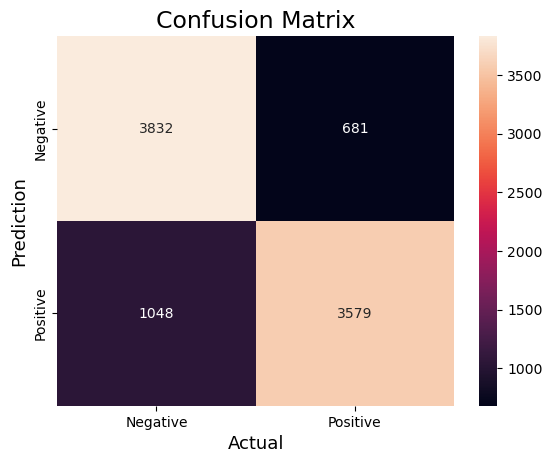

In [174]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, 
            annot=True,
            fmt='g', 
            xticklabels=['Negative','Positive'],
            yticklabels=['Negative','Positive'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()